In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'recipe-for-rating-predict-food-ratings-using-ml:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F67079%2F7452256%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240612%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240612T115139Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D742d05099a851035bf2cba99f613b49f37b5cf38ca5bb080b0f6ff19b91b09276baf93a43113d2b499afa6f40c11a8fb3643ec21096a6a14791256a8d647bbe045287565ec87ee0f1534f0443096226b4948d38a73abec751288e1517650d9715f8111e2ab590be0bf6478228bad546416c5099f02d9d8790d4fe669e030e42208299c001a8d80bb94bbace41dac5de45b6bbace76a90bd19c7079526f4497911be0e99b0c1b31638012eac4d8b261349c48f8119594db1d866cd4e34b024a1709cf49e3a8c3efaa77e77334f318962dbc31114105422a023b28418efcde82ad722f7c0ae6d77d0b9d512bd029cd8e038bdabe97d5f8a877dec6c9bcf12785b9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2426532 bytes downloaded
Downloaded and uncompressed: recipe-for-rating-predict-food-ratings-using-ml
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv


In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge,RidgeCV, SGDRegressor
from sklearn.metrics import mean_squared_error,classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV,cross_val_score, cross_validate,KFold,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,OneHotEncoder,LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd

#  **1. Data loading and storing**


In [4]:
import pandas as pd
data_train = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv")
data_test=pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv")
df=data_train.copy()

# **2. EXPLORATORY DATA ANALYSIS**

In [5]:
print("TRAIN DATA:", data_train.shape)
print("TEST DATA:", data_test.shape)
print(data_train.info())
print(data_test.info())
data_train.head()

TRAIN DATA: (13636, 15)
TEST DATA: (4546, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


In [6]:
data_test.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore,Recipe_Review
0,86,45,41384,Black Bean ‘n’ Pumpkin Chili,sp_aUSaElGf_41384_c_341929,u_1oKc4U6bh65cEli8Z8eTIf98Vpr,kalloween,1,1622718043,0,0,0,100,This was so good!! The pumpkin was perfect as...
1,102,53,3143,Pumpkin Bars,sp_aUSaElGf_3143_c_274545,u_1oKW5seFLQMSwAeOfBVmwJizy5D,chocolate desert,1,1622717685,0,0,1,100,"So good! Could not stop eating them, so bad...."
2,156,53,3143,Pumpkin Bars,sp_aUSaElGf_3143_c_398512,u_1oKZ6GUIAIol8xe6oEI7t1Mpxdz,Vantreesta,1,1622718307,0,0,0,100,I use a small ladle to fill muffin cups.
3,18,89,1324,Porcupine Meatballs,sp_aUSaElGf_1324_c_431662,u_1oKWCP33NVk4Osfpu4VJuIckEF0,Roberta L.Beauchamp,1,1622648872,0,4,3,212,I made this and followed the instructions as d...
4,27,70,32264,Easy Chicken Enchiladas,sp_aUSaElGf_32264_c_423935,u_1oKVhIJMuUlrSCVkbO1jheVTol8,fhquilting,1,1622718460,0,0,1,100,Very Good! I used corn tortillas. Used fresh...


In [7]:
data_train['Rating'].unique()

array([5, 3, 4, 0, 2, 1])

In [8]:
data_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,13636.0,1.210853e+02,1.169956e+02,0.000000e+00,4.500000e+01,9.100000e+01,1.480000e+02,7.240000e+02
RecipeNumber,13636.0,3.862438e+01,2.967235e+01,1.000000e+00,1.200000e+01,3.300000e+01,6.300000e+01,1.000000e+02
RecipeCode,13636.0,2.178599e+04,2.388319e+04,3.860000e+02,6.504000e+03,1.460000e+04,3.312100e+04,1.917750e+05
UserReputation,13636.0,2.160311e+00,1.008642e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.100000e+02
CreationTimestamp,13636.0,1.623713e+09,5.444020e+06,1.613035e+09,1.622717e+09,1.622718e+09,1.622718e+09,1.665756e+09
ReplyCount,13636.0,1.452039e-02,1.373234e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
ThumbsUpCount,13636.0,1.098269e+00,4.166487e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+01
ThumbsDownCount,13636.0,5.437078e-01,3.265660e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.260000e+02
Rating,13636.0,4.288721e+00,1.544839e+00,0.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
BestScore,13636.0,1.531279e+02,1.409869e+02,0.000000e+00,1.000000e+02,1.000000e+02,1.000000e+02,9.460000e+02


# **Identifying feature type**

In [9]:
target = data_train.columns[-3:-2].values[0]
print("Target:", target)
print()
features= list(data_train.columns.values)
features.remove(target)
print("FeaturesList:", features)
print()
print("Total Features:", len(features))
print()
numCols = list(data_train.select_dtypes("number").columns)
catCols = list(data_train.select_dtypes(exclude = "number").columns)
print("categorical features:", catCols)
print()
print("numerical features:", numCols)

Target: Rating

FeaturesList: ['ID', 'RecipeNumber', 'RecipeCode', 'RecipeName', 'CommentID', 'UserID', 'UserName', 'UserReputation', 'CreationTimestamp', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'BestScore', 'Recipe_Review']

Total Features: 14

categorical features: ['RecipeName', 'CommentID', 'UserID', 'UserName', 'Recipe_Review']

numerical features: ['ID', 'RecipeNumber', 'RecipeCode', 'UserReputation', 'CreationTimestamp', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore']


In [10]:
data_train.isin(values=['?',np.nan]).sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        2
dtype: int64

**Key Points**
* **The data has 14 features and 1 target variable.**
* **There are 5 categorical features, the rest are numerical.**
* **The Recipe_Review has 13634 values while the shape is 13636, implying there is 2 missing value(to be imputed).**

# **Data Visualization**

array([[<Axes: title={'center': 'ID'}>,
        <Axes: title={'center': 'RecipeNumber'}>,
        <Axes: title={'center': 'RecipeCode'}>],
       [<Axes: title={'center': 'UserReputation'}>,
        <Axes: title={'center': 'CreationTimestamp'}>,
        <Axes: title={'center': 'ReplyCount'}>],
       [<Axes: title={'center': 'ThumbsUpCount'}>,
        <Axes: title={'center': 'ThumbsDownCount'}>,
        <Axes: title={'center': 'Rating'}>],
       [<Axes: title={'center': 'BestScore'}>, <Axes: >, <Axes: >]],
      dtype=object)

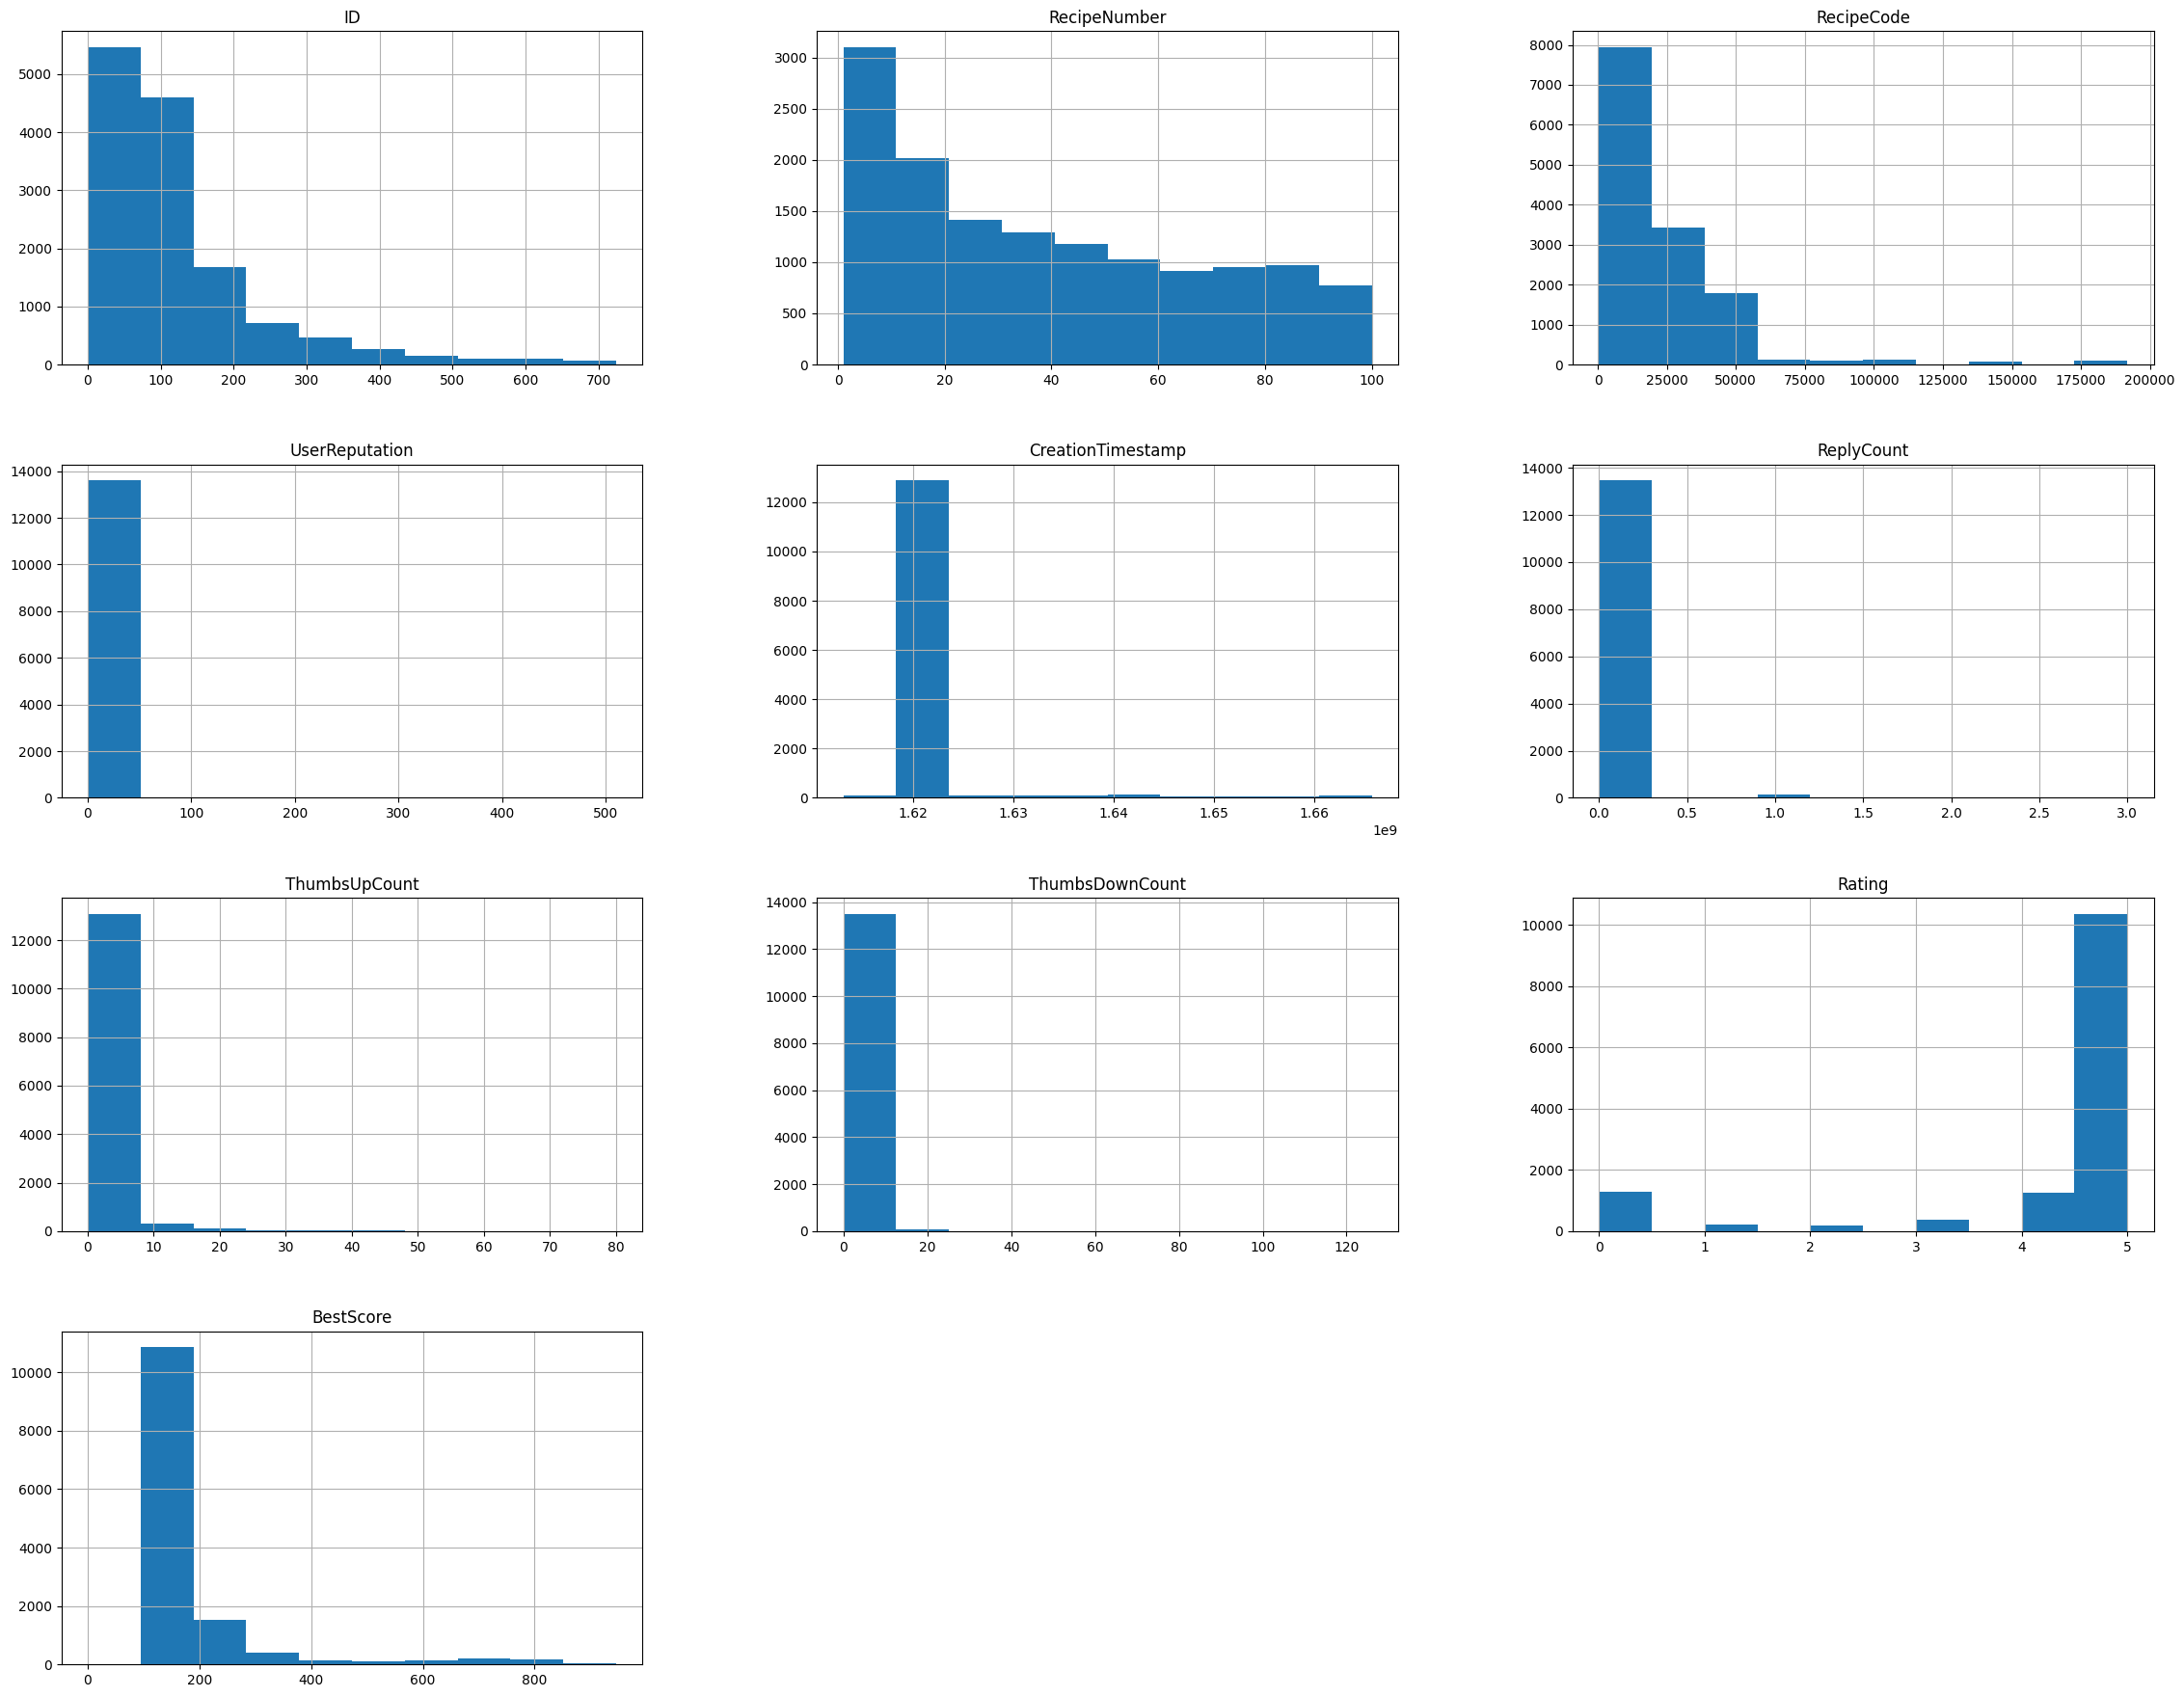

In [11]:
data_train.hist(figsize=(28,22))

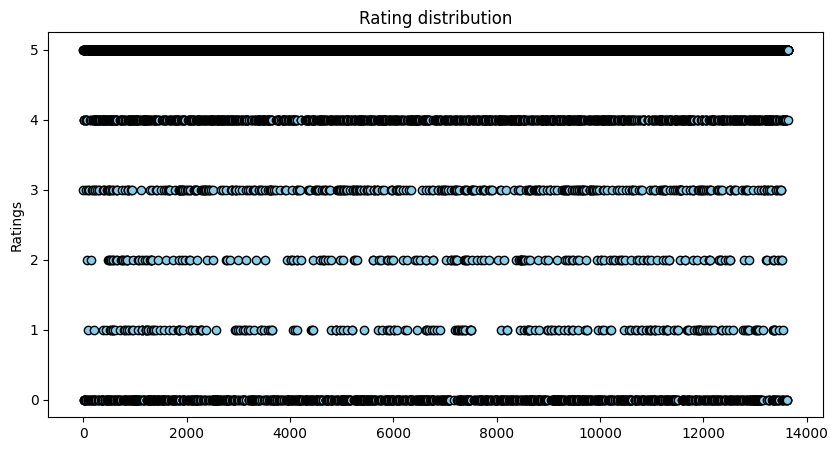

In [12]:
##SCATTER PLOT OF THE TARGET VARIABLE: Rating
plt.figure(figsize=(10, 5))
plt.scatter(range(len(data_train['Rating'])), data_train['Rating'], color='skyblue', edgecolor='black')
plt.title('Rating distribution')
plt.ylabel('Ratings')
plt.show()

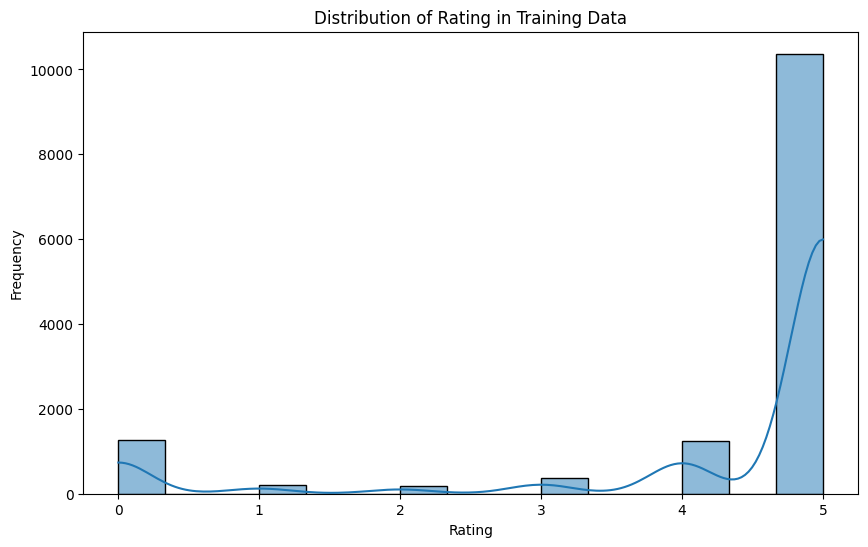

In [13]:
# Visualize the distribution of the target variable (Rating) in the training data
plt.figure(figsize=(10, 6))
sns.histplot(data_train['Rating'], kde=True)
plt.title('Distribution of Rating in Training Data')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

**Data is Imbalanced**

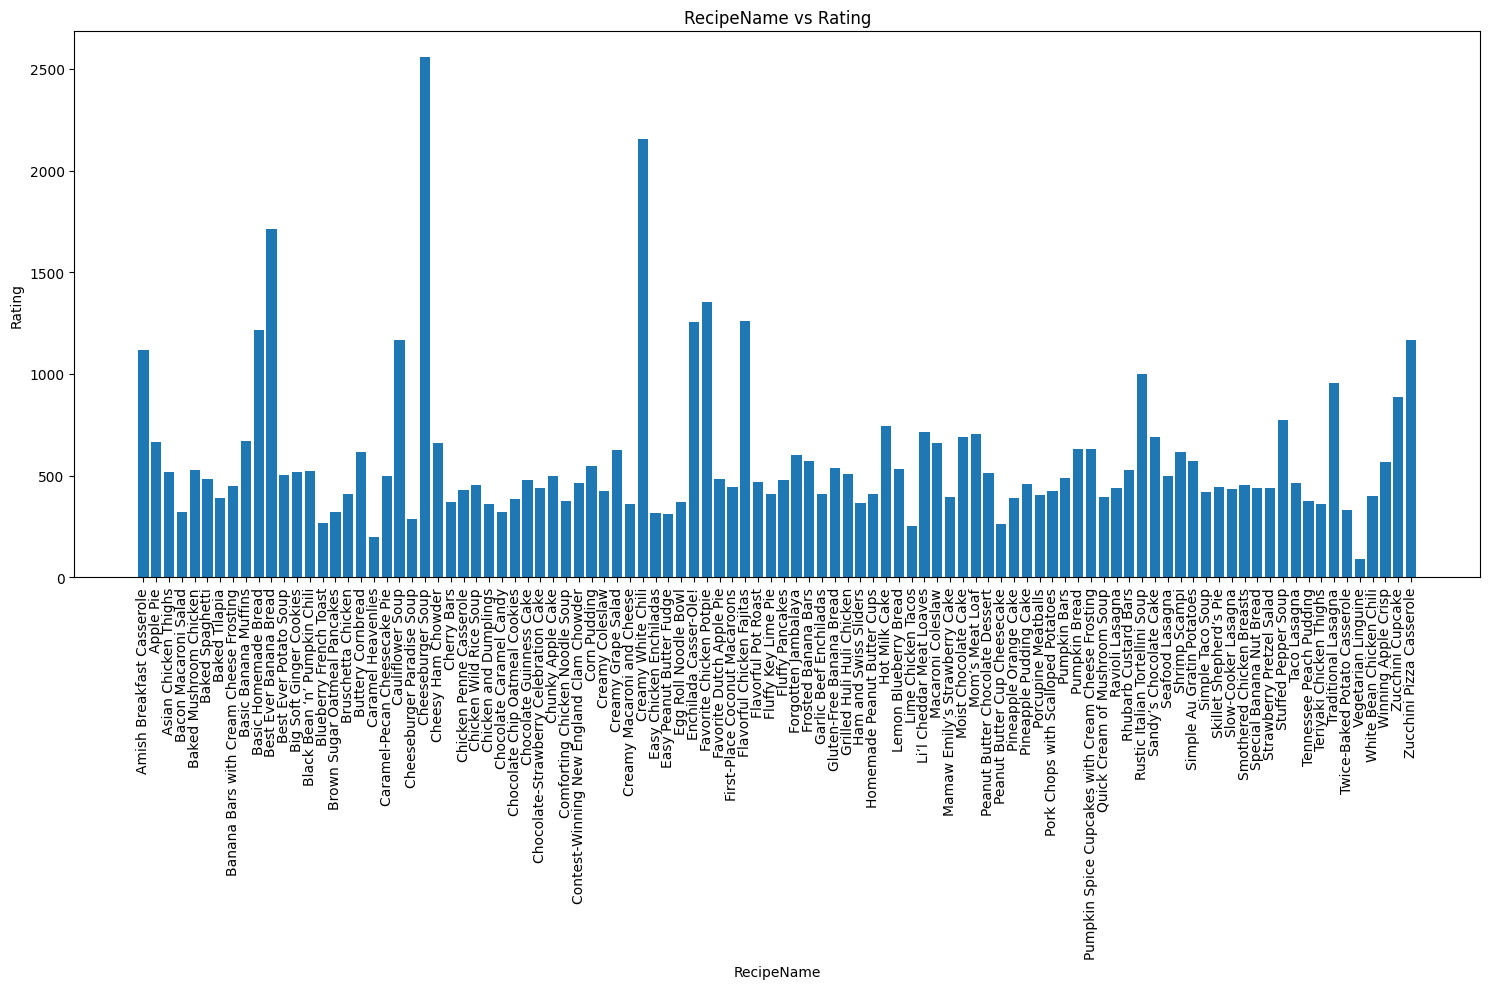

In [14]:
import matplotlib.pyplot as plt

# Assuming 'data_train' is your training dataset and it contains the necessary columns
grouped_data = data_train.groupby('RecipeName')['Rating'].sum().reset_index()

plt.figure(figsize=(15, 10))  # Adjust the figure size to make the x-axis larger

plt.bar(grouped_data['RecipeName'], grouped_data['Rating'])
plt.xlabel('RecipeName')
plt.ylabel('Rating')
plt.title('RecipeName vs Rating')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

In [15]:
# Group by RecipeName and count the number of ratings for each recipe
ratings_count = data_train.groupby('RecipeName')['Rating'].count()

# Find the recipe with the most ratings
most_rated_recipe = ratings_count.idxmax()

# Find the recipe with the least ratings
least_rated_recipe = ratings_count.idxmin()

print("Recipe with the most ratings:", most_rated_recipe)
print("Recipe with the least ratings:", least_rated_recipe)

Recipe with the most ratings: Cheeseburger Soup
Recipe with the least ratings: Vegetarian Linguine


**CHECKING FOR OUTLIERS IN ThumbsUpCount AND ThumbsDownCount**

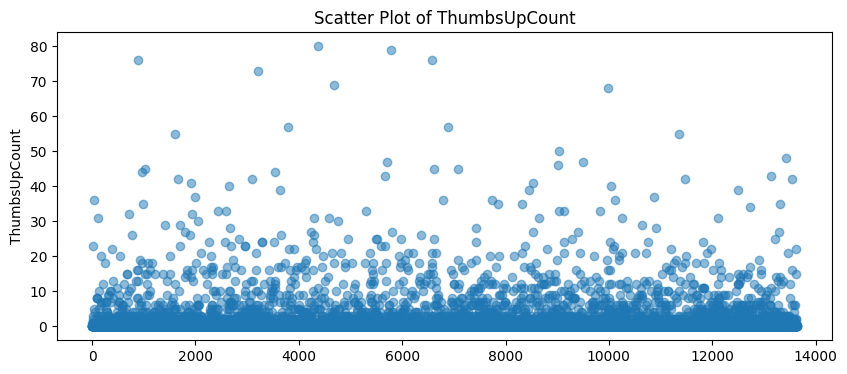

882                           Porcupine Meatballs
1605                                Pumpkin Bread
3207                             Cauliflower Soup
3781                          Flavorful Pot Roast
4369     Contest-Winning New England Clam Chowder
4686                            Cheeseburger Soup
5776           Pork Chops with Scalloped Potatoes
6578                          Traditional Lasagna
6891                        Ham and Swiss Sliders
9028                             Cauliflower Soup
9986                        Enchilada Casser-Ole!
11358               First-Place Coconut Macaroons
Name: RecipeName, dtype: object

In [16]:
## ARE THERE OUTLIERS IN ThumbsUpCount?
plt.figure(figsize=(10,4))
plt.scatter(data_train.index, data_train['ThumbsUpCount'], alpha=0.5)
plt.title('Scatter Plot of ThumbsUpCount')
plt.ylabel('ThumbsUpCount')
plt.show()

trip_distance_outlier_rows = data_train[(data_train['ThumbsUpCount'] >= 50)]
trip_distance_outlier_rows["RecipeName"]


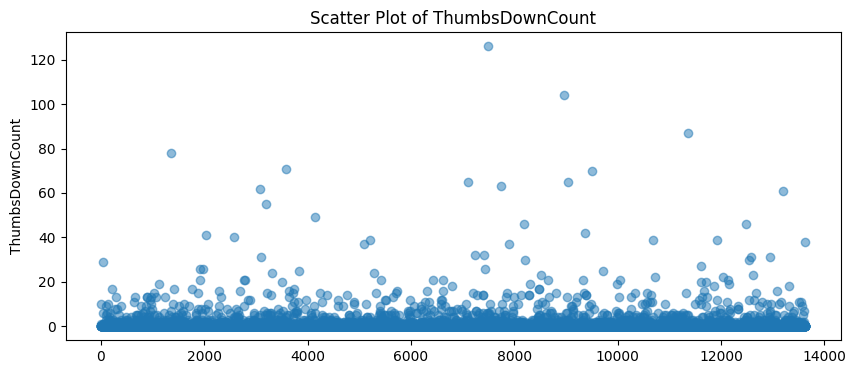

1353         Simple Au Gratin Potatoes
3082                   Mom’s Meat Loaf
3192                      Pumpkin Bars
3582          White Bean Chicken Chili
7096          White Bean Chicken Chili
7491                  Simple Taco Soup
7745             Best Ever Potato Soup
8968            Skillet Shepherd’s Pie
9037          Easy Peanut Butter Fudge
9499         Simple Au Gratin Potatoes
11358    First-Place Coconut Macaroons
13202                Cheeseburger Soup
Name: RecipeName, dtype: object

In [17]:
## ARE THERE OUTLIERS IN ThumbsDownCount?
plt.figure(figsize=(10,4))
plt.scatter(data_train.index, data_train['ThumbsDownCount'], alpha=0.5)
plt.title('Scatter Plot of ThumbsDownCount')
plt.ylabel('ThumbsDownCount')
plt.show()

trip_distance_outlier_rows = data_train[(data_train['ThumbsDownCount'] >= 50)]
trip_distance_outlier_rows["RecipeName"]

## LOOKS LIKE THERE ARE 4 OUTLIERS IN TRIP DISTANCE (BECAUSE TRIP DISTANCE CANNOT BE SO HIGH)

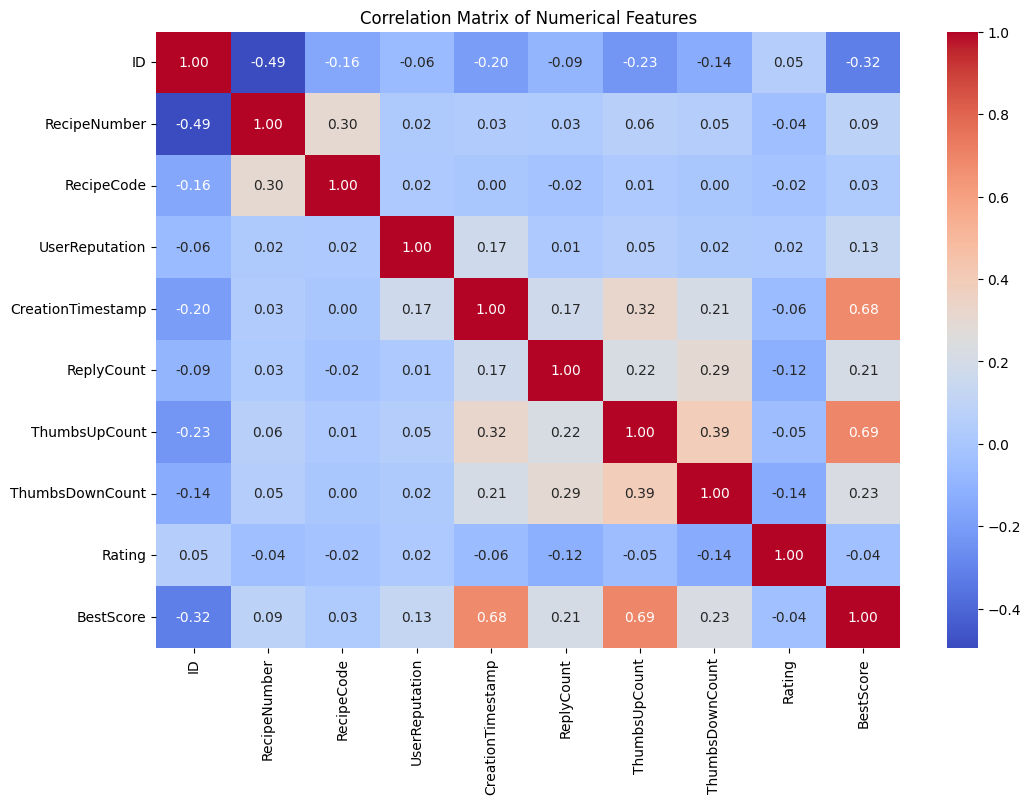

In [18]:
numeric_columns = data_train.select_dtypes(include=['number']).columns
correlation_matrix = data_train[numeric_columns].corr()

# Visualize correlation matrix for numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

**Key Points**
* **ThumbsUpCount: Outliers in thumbs-up counts could indicate recipes that are exceptionally well-liked by users. These outliers might have a strong positive influence on the predicted rating.**

* **ThumbsDownCount: Outliers in thumbs-down counts might indicate recipes that are controversial or disliked by users. These outliers could have a strong negative influence on the predicted rating.**

* **There is no much correlation between the target and the other numerical features.**

# **3. Preprocessing**

# IMPUTING MISSING VALUES
* **Dropped the two rows with missing values**

In [19]:
data_train = data_train.dropna()
data_train.isin(values=['?',np.nan]).sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        0
dtype: int64

In [20]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
le = LabelEncoder()

# List of categorical columns to be encoded
categorical_columns = ['RecipeName', 'CommentID', 'UserID', 'UserName']

# Loop through each categorical column in the DataFrame and apply LabelEncoder
for column in categorical_columns:
    data_train[column + '_encoded'] = le.fit_transform(data_train[column])
    # To replace the original column with the encoded one
    data_train[column] = data_train[column + '_encoded']

# Display the transformed DataFrame
data_train.head()



<ipython-input-20-5b5b2773d09b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train[column + '_encoded'] = le.fit_transform(data_train[column])
<ipython-input-20-5b5b2773d09b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train[column] = data_train[column + '_encoded']


,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review,RecipeName_encoded,CommentID_encoded,UserID_encoded,UserName_encoded
0,70,71,12259,7,1409,324,8684,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...,7,1409,324,8684
1,72,88,8202,83,12900,7085,3639,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...,83,12900,7085,3639
2,458,3,2832,22,6038,5937,7331,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...,22,6038,5937,7331
3,7,50,100276,55,120,6745,6557,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...,55,120,6745,6557
4,60,12,19731,20,4533,9417,4721,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...,20,4533,9417,4721


In [21]:
numCols = list(data_train.select_dtypes("number").columns)
catCols = list(data_train.select_dtypes(exclude = "number").columns)
print("categorical features:", catCols)
print()
print("numerical features:", numCols)

categorical features: ['Recipe_Review']

numerical features: ['ID', 'RecipeNumber', 'RecipeCode', 'RecipeName', 'CommentID', 'UserID', 'UserName', 'UserReputation', 'CreationTimestamp', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore', 'RecipeName_encoded', 'CommentID_encoded', 'UserID_encoded', 'UserName_encoded']


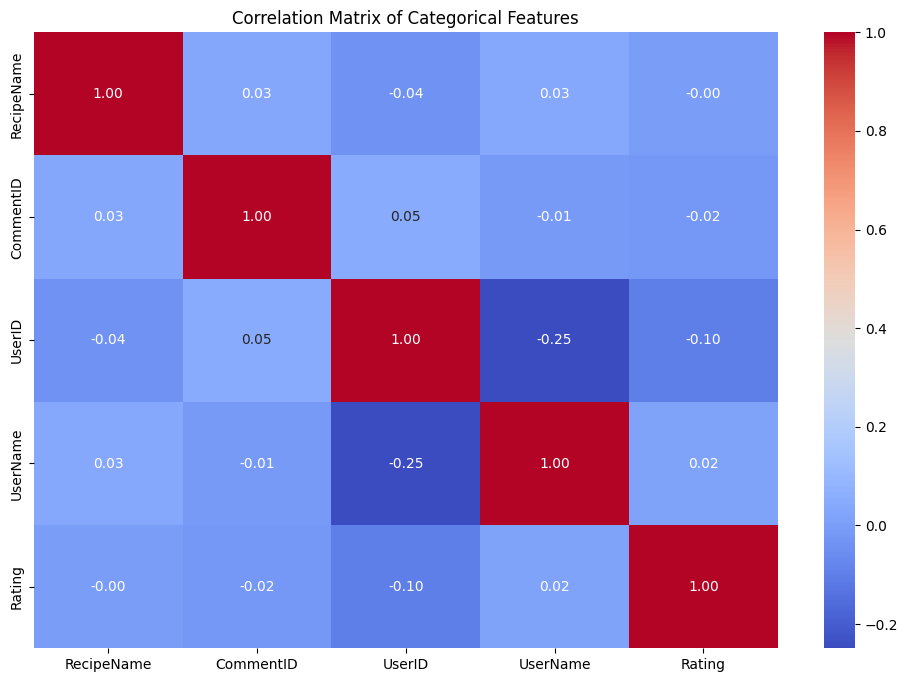

In [22]:
cat_columns = ['RecipeName', 'CommentID', 'UserID', 'UserName','Rating']
correlation_matrix = data_train[cat_columns].corr()

# Visualize correlation matrix for numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Categorical Features')
plt.show()

In [23]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# List of numerical columns
numerical_columns =['ID', 'RecipeNumber', 'RecipeCode', 'UserReputation', 'CreationTimestamp', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'BestScore']
# Standardize the numerical columns directly
data_train[numerical_columns] = scaler.fit_transform(data_train[numerical_columns])

# Now the original numerical columns are updated with standardized values
data_train.head()


,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review,RecipeName_encoded,CommentID_encoded,UserID_encoded,UserName_encoded
0,-0.436471,1.091001,-0.398953,7,1409,324,8684,1.768603,-0.183034,-0.10575,-0.263626,-0.166511,5,-0.376874,great recipe! I have made them just as written...,7,1409,324,8684
1,-0.419373,1.663960,-0.568819,83,12900,7085,3639,-0.115050,-0.182892,-0.10575,-0.263626,0.139695,5,-0.376874,This is an easy and quick recipe that is great...,83,12900,7085,3639
2,2.880494,-1.200833,-0.793661,22,6038,5937,7331,-0.115050,-0.182983,-0.10575,-0.263626,-0.166511,3,-0.376874,I think I was looking for something extra spec...,22,6038,5937,7331
3,-0.975050,0.383229,3.286308,55,120,6745,6557,-0.115050,-0.195558,-0.10575,-0.263626,-0.166511,5,-0.376874,This is our favorite grilled chicken recipe. ...,55,120,6745,6557
4,-0.521959,-0.897502,-0.086101,20,4533,9417,4721,-0.115050,-0.182817,-0.10575,-0.263626,-0.166511,4,-0.376874,Great basic recipe. I added 2 teaspoons Tuscan...,20,4533,9417,4721


**Key Points**

* **There is no much correlation between the target and the other categorical features.**
* **Used LabelEncoder to convert the categorical variables to numerical.**
* **StandardScaler to Standardize.**

#  **4. Traing and testing the models & Feature Engineering/Extraction**

# **1. MultinomialNB**

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_train['Recipe_Review'], data_train['Rating'], random_state=42)

# Create a pipeline with CountVectorizer and Multinomial Naive Bayes
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

# Set up parameter grid for hyperparameter tuning
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],  # Adjust n-gram range
    'vect__max_df': [0.8, 1.0],  # Adjust max document frequency
    'clf__alpha': [0.1, 0.5, 1.0]  # Adjust alpha smoothing parameter
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(text_clf, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Predict on the test set using the best model
best_model = grid_search.best_estimator_
predicted = best_model.predict(X_test)

# Print classification report and confusion matrix
print(classification_report(y_test, predicted))
print('Confusion Matrix:')
print(confusion_matrix(y_test, predicted))

data_train['Score'] = best_model.predict(data_train['Recipe_Review'])

# Display the updated dataset with the new 'Score' column
print(data_train[['Recipe_Review', 'Rating', 'Score']])

data_test['Score'] = best_model.predict(data_test['Recipe_Review'])

result=best_model.predict(data_test["Recipe_Review"])

#Create a DataFrame for the predictions using Multinomial Naive Bayes
predictions_df_rf = pd.DataFrame({'ID': range(1, 4547), 'Rating': result})

# Display the predictions DataFrame using Multinomial Naive Bayes
print(predictions_df_rf)

predictions_df_rf.to_csv('submission.csv', index=False)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
# Calculate predicted probabilities for each class
predicted_proba = best_model.predict_proba(X_test)

# Binarize the true labels
from sklearn.preprocessing import label_binarize
y_test_binary = label_binarize(y_test, classes=np.unique(y_test))

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], predicted_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_binary.ravel(), predicted_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})', color='deeppink', linestyle=':')
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], label=f'ROC Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Calculate precision and recall for each class
precision = dict()
recall = dict()
for i in range(len(np.unique(y_test))):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binary[:, i], predicted_proba[:, i])

# Plot PR curve
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_test))):
    plt.plot(recall[i], precision[i], label=f'PR Curve Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

In [ ]:
numeric_columns = data_train.select_dtypes(include=['number']).columns
correlation_matrix = data_train[numeric_columns].corr()

# Visualize correlation matrix for numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# **MultinomialNB**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_train['Recipe_Review'], data_train['Rating'], random_state=42)

# Create a pipeline with TfidfVectorizer and Multinomial Naive Bayes
text_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Set up parameter grid for hyperparameter tuning
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],  # Adjust n-gram range
    'vect__max_df': [0.8, 1.0],  # Adjust max document frequency
    'clf__alpha': [0.1, 0.5, 1.0]  # Adjust alpha smoothing parameter
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(text_clf, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Predict on the test set using the best model
best_model = grid_search.best_estimator_
predicted = best_model.predict(X_test)

# Print classification report and confusion matrix
print(classification_report(y_test, predicted))
print('Confusion Matrix:')
print(confusion_matrix(y_test, predicted))

data_train['Score'] = best_model.predict(data_train['Recipe_Review'])

# Display the updated dataset with the new 'Score' column
print(data_train[['Recipe_Review', 'Rating', 'Score']])

data_test['Score'] = best_model.predict(data_test['Recipe_Review'])

result = best_model.predict(data_test["Recipe_Review"])

# Create a DataFrame for the predictions using Multinomial Naive Bayes
predictions_df_nb = pd.DataFrame({'ID': range(1, 4547), 'Rating': result})

# Display the predictions DataFrame using Multinomial Naive Bayes
print(predictions_df_nb)

#predictions_df_nb.to_csv('submission.csv', index=False)


**Got a public score of 0.7655**

In [ ]:
# Calculate predicted probabilities for each class
predicted_proba = best_model.predict_proba(X_test)

# Binarize the true labels
from sklearn.preprocessing import label_binarize
y_test_binary = label_binarize(y_test, classes=np.unique(y_test))

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], predicted_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_binary.ravel(), predicted_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})', color='deeppink', linestyle=':')
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], label=f'ROC Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Calculate precision and recall for each class
precision = dict()
recall = dict()
for i in range(len(np.unique(y_test))):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binary[:, i], predicted_proba[:, i])

# Plot PR curve
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_test))):
    plt.plot(recall[i], precision[i], label=f'PR Curve Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

# **2. BernoulliNB**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_train['Recipe_Review'], data_train['Rating'], random_state=42)

# Create a pipeline with CountVectorizer and Bernoulli Naive Bayes
text_clf = Pipeline([
    ('vect', CountVectorizer(binary=True)),  # Set binary=True for BernoulliNB
    ('clf', BernoulliNB())
])

# Set up parameter grid for hyperparameter tuning
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],  # Adjust n-gram range
    'vect__max_df': [0.8, 1.0],  # Adjust max document frequency
    'clf__alpha': [0.1, 0.5, 1.0]  # Adjust alpha smoothing parameter
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(text_clf, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Predict on the test set using the best model
best_model = grid_search.best_estimator_
predicted = best_model.predict(X_test)

# Print classification report and confusion matrix
print(classification_report(y_test, predicted))
print('Confusion Matrix:')
print(confusion_matrix(y_test, predicted))

# Update the dataset with the predicted scores
data_train['Score'] = best_model.predict(data_train['Recipe_Review'])

# Display the updated dataset with the new 'Score' column
print(data_train[['Recipe_Review', 'Rating', 'Score']])

# Predict using the best model on the test dataset
result = best_model.predict(data_test['Recipe_Review'])

# Create a DataFrame for the predictions using Bernoulli Naive Bayes
predictions_df_nb = pd.DataFrame({'ID': range(1,  4547), 'Rating': result})

# Display the predictions DataFrame using Bernoulli Naive Bayes
print(predictions_df_nb)

# Save predictions to a CSV file
#predictions_df_nb.to_csv('submission.csv', index=False)


**Got a public score of 0.76**

In [ ]:
# Calculate predicted probabilities for each class
predicted_proba = best_model.predict_proba(X_test)

# Binarize the true labels
from sklearn.preprocessing import label_binarize
y_test_binary = label_binarize(y_test, classes=np.unique(y_test))

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], predicted_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_binary.ravel(), predicted_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})', color='deeppink', linestyle=':')
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], label=f'ROC Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Calculate precision and recall for each class
precision = dict()
recall = dict()
for i in range(len(np.unique(y_test))):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binary[:, i], predicted_proba[:, i])

# Plot PR curve
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_test))):
    plt.plot(recall[i], precision[i], label=f'PR Curve Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

# **3. DecisionTreeClassifier**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Assuming data_train is your training data DataFrame with 'Recipe_Review' and 'Rating' columns
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_train['Recipe_Review'], data_train['Rating'], random_state=42)

# Create a pipeline with CountVectorizer and Decision Tree Classifier
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),  # Using CountVectorizer without binary=True
    ('clf', DecisionTreeClassifier(max_depth=10, max_leaf_nodes=20, random_state=42))  # Using Decision Tree Classifier
])


pipeline.fit(X_train, y_train)

# Print the best hyperparameters

# Predict on the test set using the best model
predicted = pipeline.predict(X_test)

# Print classification report and confusion matrix
print(classification_report(y_test, predicted))
print('Confusion Matrix:')
print(confusion_matrix(y_test, predicted))

# Update the dataset with the predicted scores
data_train['Score'] = best_model.predict(data_train['Recipe_Review'])

# Display the updated dataset with the new 'Score' column
print(data_train[['Recipe_Review', 'Rating', 'Score']])

# Assuming data_test is your test data DataFrame with 'Recipe_Review' column
# Predict using the best model on the test dataset
result = best_model.predict(data_test['Recipe_Review'])

# Create a DataFrame for the predictions using Decision Tree Classifier
predictions_df_dt = pd.DataFrame({'ID': range(1, 4547), 'Rating': result})

# Display the predictions DataFrame using Decision Tree Classifier
print(predictions_df_dt)

# Save predictions to a CSV file
#predictions_df_dt.to_csv('submission.csv', index=False)


**Got a public score of 0.76**

In [ ]:
# Calculate predicted probabilities for each class
predicted_proba = pipeline.predict_proba(X_test)

# Binarize the true labels
from sklearn.preprocessing import label_binarize
y_test_binary = label_binarize(y_test, classes=pipeline.classes_)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(pipeline.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], predicted_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(pipeline.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'ROC Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Calculate precision and recall for each class
precision = dict()
recall = dict()
for i in range(len(pipeline.classes_)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binary[:, i], predicted_proba[:, i])

# Plot PR curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(pipeline.classes_)):
    plt.plot(recall[i], precision[i], label=f'PR Curve Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

* **Pipeline for extracting Score corresponding to Recipe_Review**
* **Hyperparameter tuning of model to optimize its performance(before Hyper parameter tuning the accuracy and F1 score was bad)**

# Highlights
> **MultinomialNB, BernoulliNB and DecisionTreeClassifier are some of the best performing models**

> **Best submission score achieved 0.77342 by MultinomialNB**
